Caricare il dataset ed eseguire tutto, poi scaricare il dataset aggiornato e il modello.

In [ ]:
import itertools
import json
import pandas as pd
import numpy as np
import datetime
from prophet import Prophet
from prophet.serialize import model_to_json
from prophet.diagnostics import cross_validation, performance_metrics

In [ ]:
# --- FUNZIONI DI SUPPORTO

# from_date: datetime che rappresenta data e ora a partire dalle quali sono generati i timestamp
# periods: il numero di giorni per cui si vogliono generare date
# interval_mins: intervallo tra due timestamp successivi (in minuti)
def make_future_dataframe(from_date, periods, interval_mins):
  timestamps = []
  MINUTES_PER_DAY = 1440
  n_samples = (MINUTES_PER_DAY // interval_mins) * periods
  
  for i in range(n_samples + 1):
    if i > 0:
      from_date += datetime.timedelta(minutes=interval_mins)
    timestamps.append(str(from_date))

  return pd.DataFrame({ 'ds': timestamps })

In [ ]:
feed = "location-1"
timezone = "UTC"

# caricamento dei dati del feed e preprocessing
feed_data = pd.read_csv(feed + ".csv", sep=";")
feed_data = feed_data.loc[:, ["created_at", "value"]]
feed_data["created_at"] = \
  feed_data["created_at"].apply(lambda x: x.replace(" " + timezone, ""))

feed_data

,created_at,value
0,2021-07-24 00:00:00,0
1,2021-07-24 00:30:00,0
2,2021-07-24 01:00:00,0
3,2021-07-24 01:30:00,0
4,2021-07-24 02:00:00,0
...,...,...
5035,2021-11-05 21:30:00,31
5036,2021-11-05 22:00:00,30
5037,2021-11-05 22:30:00,30
5038,2021-11-05 23:00:00,30


In [ ]:
feed_data_periods = len(feed_data) / 48.0
now = datetime.datetime.now()
now_at_midnight = datetime.datetime(now.year, now.month, now.day)
starting_date = now_at_midnight - datetime.timedelta(days=feed_data_periods)
updated_timestamps = make_future_dataframe(from_date=starting_date, periods=105, interval_mins=30).iloc[:, 0]
updated_timestamps.name = 'created_at'
updated_timestamps

0       2021-11-29 00:00:00
1       2021-11-29 00:30:00
2       2021-11-29 01:00:00
3       2021-11-29 01:30:00
4       2021-11-29 02:00:00
               ...         
5036    2022-03-13 22:00:00
5037    2022-03-13 22:30:00
5038    2022-03-13 23:00:00
5039    2022-03-13 23:30:00
5040    2022-03-14 00:00:00
Name: created_at, Length: 5041, dtype: object

In [ ]:
feed_data['created_at'] = updated_timestamps
feed_data.to_csv(f"{ feed}.csv", sep=';', index=False)
feed_data

,created_at,value
0,2021-11-29 00:00:00,0
1,2021-11-29 00:30:00,0
2,2021-11-29 01:00:00,0
3,2021-11-29 01:30:00,0
4,2021-11-29 02:00:00,0
...,...,...
5035,2022-03-13 21:30:00,31
5036,2022-03-13 22:00:00,30
5037,2022-03-13 22:30:00,30
5038,2022-03-13 23:00:00,30


In [ ]:
feed_data.columns = ['ds', 'y']

In [ ]:
model = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=10.0)
model.fit(feed_data)

with open(f'{ feed }.json', 'w') as fout:
    json.dump(model_to_json(model), fout)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


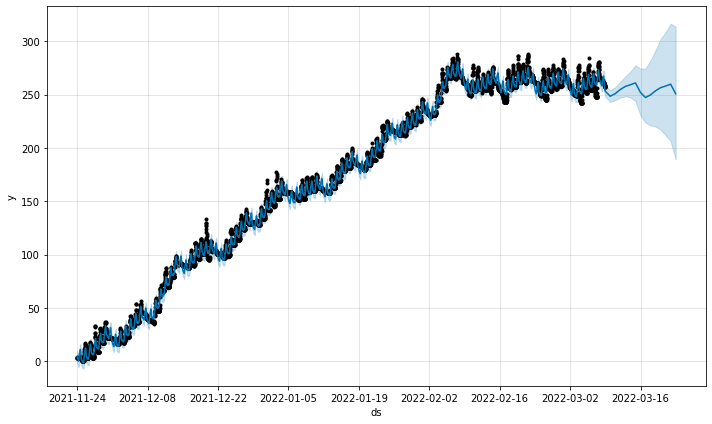

In [ ]:
future_dataframe = model.make_future_dataframe(periods=14)
forecast = model.predict(future_dataframe)
model.plot(forecast)
pass

In [ ]:
(forecast['yhat_upper'] - forecast['yhat_lower']).describe()

count    5054.000000
mean       10.677998
std         3.018607
min         9.471676
25%        10.353852
50%        10.561762
75%        10.760654
max       124.689302
dtype: float64